In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, CSVLogger
from tensorflow.keras.utils import plot_model
from keras.saving import save_model, load_model
import matplotlib.pyplot as plt
from keras import layers
import tensorflow as tf
from PIL import Image
from glob import glob
import numpy as np
import pickle
import shutil
import random
import keras
import os
import gc
os.environ["KERAS_BACKEND"] = "tensorflow"
random.seed(10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
# !unzip -q lol_dataset.zip && rm lol_dataset.zip

In [ ]:
# root_path = '/content/drive/MyDrive/Colab_Notebooks/Tasks/Enhance Dark Images'
root_path = '/content/drive/MyDrive/Colab Notebooks/Enhance Dark Images'
model_info_path = os.path.join(root_path, 'model info')
data_path = os.path.join(root_path, 'data')
IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300

In [ ]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image

In [ ]:
def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32)
    low_h = tf.random.uniform(shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32)
    low_image_cropped = low_image[low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE]
    enhanced_image_cropped = enhanced_image[low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE]
    # in order to avoid `NONE` during shape inference
    low_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    enhanced_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return low_image_cropped, enhanced_image_cropped

In [ ]:
def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image

In [ ]:
def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [ ]:
def save_object(obj, filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

def load_object(filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [ ]:
train_low_light_images = sorted(glob(os.path.join(data_path, 'our485', 'low', '*')))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob(os.path.join(data_path, 'our485', 'high', '*')))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob(os.path.join(data_path, 'our485', 'low', '*')))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob(os.path.join(data_path, 'our485', 'high', '*')))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob(os.path.join(data_path, 'eval15', 'low', '*')))
test_enhanced_images = sorted(glob(os.path.join(data_path, 'eval15', 'high', '*')))

train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)

print("Train Dataset:", train_dataset.element_spec)
print("Val Dataset:", val_dataset.element_spec)

TypeError: in user code:

    File "<ipython-input-6-aff404a5d774>", line 2, in load_data  *
        low_light_image = read_image(low_light_image_path)
    File "<ipython-input-4-b92ca4b3b619>", line 2, in read_image  *
        image = tf.io.read_file(image_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [ ]:
def our_model(channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(2, 2), padding="same")(input_tensor)
    x2 = layers.Conv2D(channels, kernel_size=(2, 2), padding="same")(x1)
    x3 =  layers.MaxPool2D(pool_size=(1, 1))(x2)
    x4 = layers.Conv2D(channels, kernel_size=(2, 2), padding="same")(x3)
    x5 = layers.Conv2D(channels*2, kernel_size=(3, 3), padding="same")(x4)
    x6 =  layers.MaxPool2D(pool_size=(1, 1))(x5)
    x7 = layers.Conv2D(channels*4, kernel_size=(3, 3), padding="same")(x6)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x7)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)
model = our_model(channels=32)

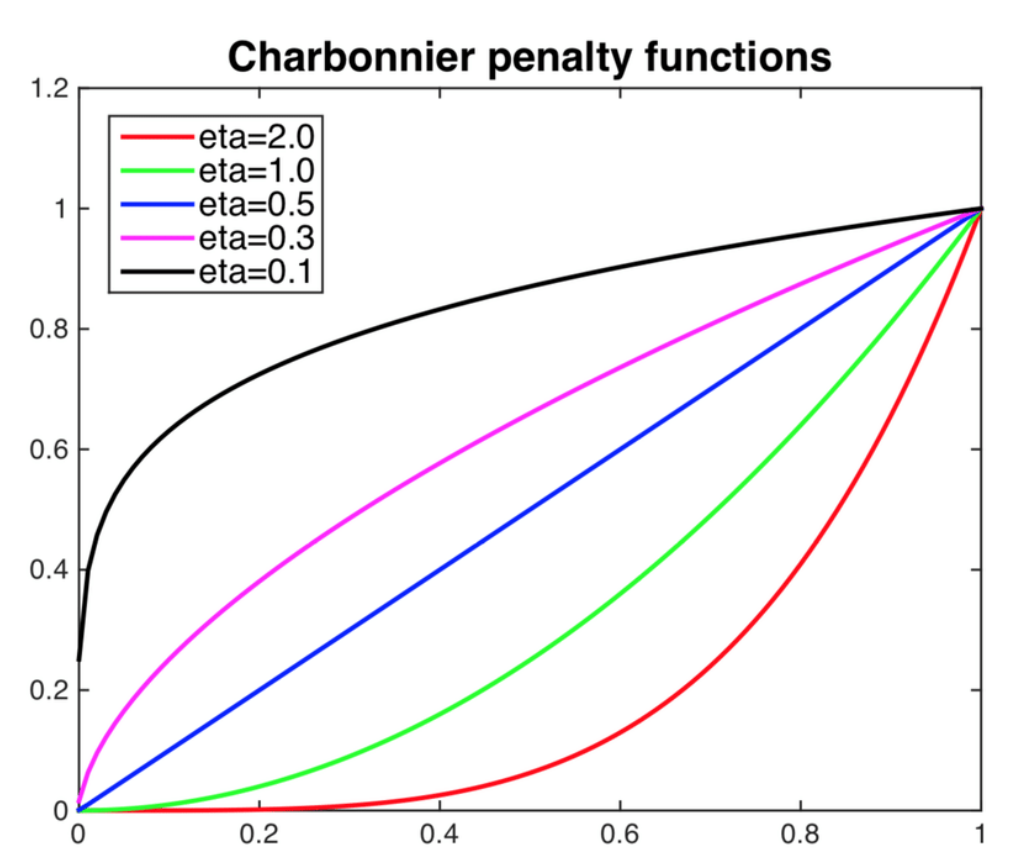



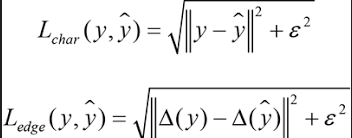

In [ ]:
from keras.saving import register_keras_serializable
@register_keras_serializable()
def charbonnier_loss(y_true, y_pred, epsilon=1e-3):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + epsilon**2))

In [ ]:
import tensorflow as tf
def peak_signal_noise_ratio(y_true, y_pred, max_val=255.0):
    return tf.image.psnr(y_pred, y_true, max_val)

In [ ]:
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

model_name = 'Enhance_Dark_Images_model'
filepath = os.path.join(model_info_path, model_name + '.best.keras')
history_logger = CSVLogger(os.path.join(model_info_path, 'History.csv'), separator=",", append=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [GarbageCollectorCallback(), checkpoint, es, history_logger,
                  keras.callbacks.ReduceLROnPlateau(monitor="val_peak_signal_noise_ratio",
                                                    factor=0.5, patience=5, verbose=1,
                                                    min_delta=1e-7, mode="max",)]

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            416 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          4,128 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 32) │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 32) │          4,128 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 64) │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, None, None, 64) │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │         73,856 │ max_pooling2d_1[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, None, None, 3)  │          3,459 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, None, None, 3)  │              0 │ input_layer[0][0],     │
│                           │                        │                │ conv2d_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 104,483 (408.14 KB)

 Trainable params: 104,483 (408.14 KB)

 Non-trainable params: 0 (0.00 B)

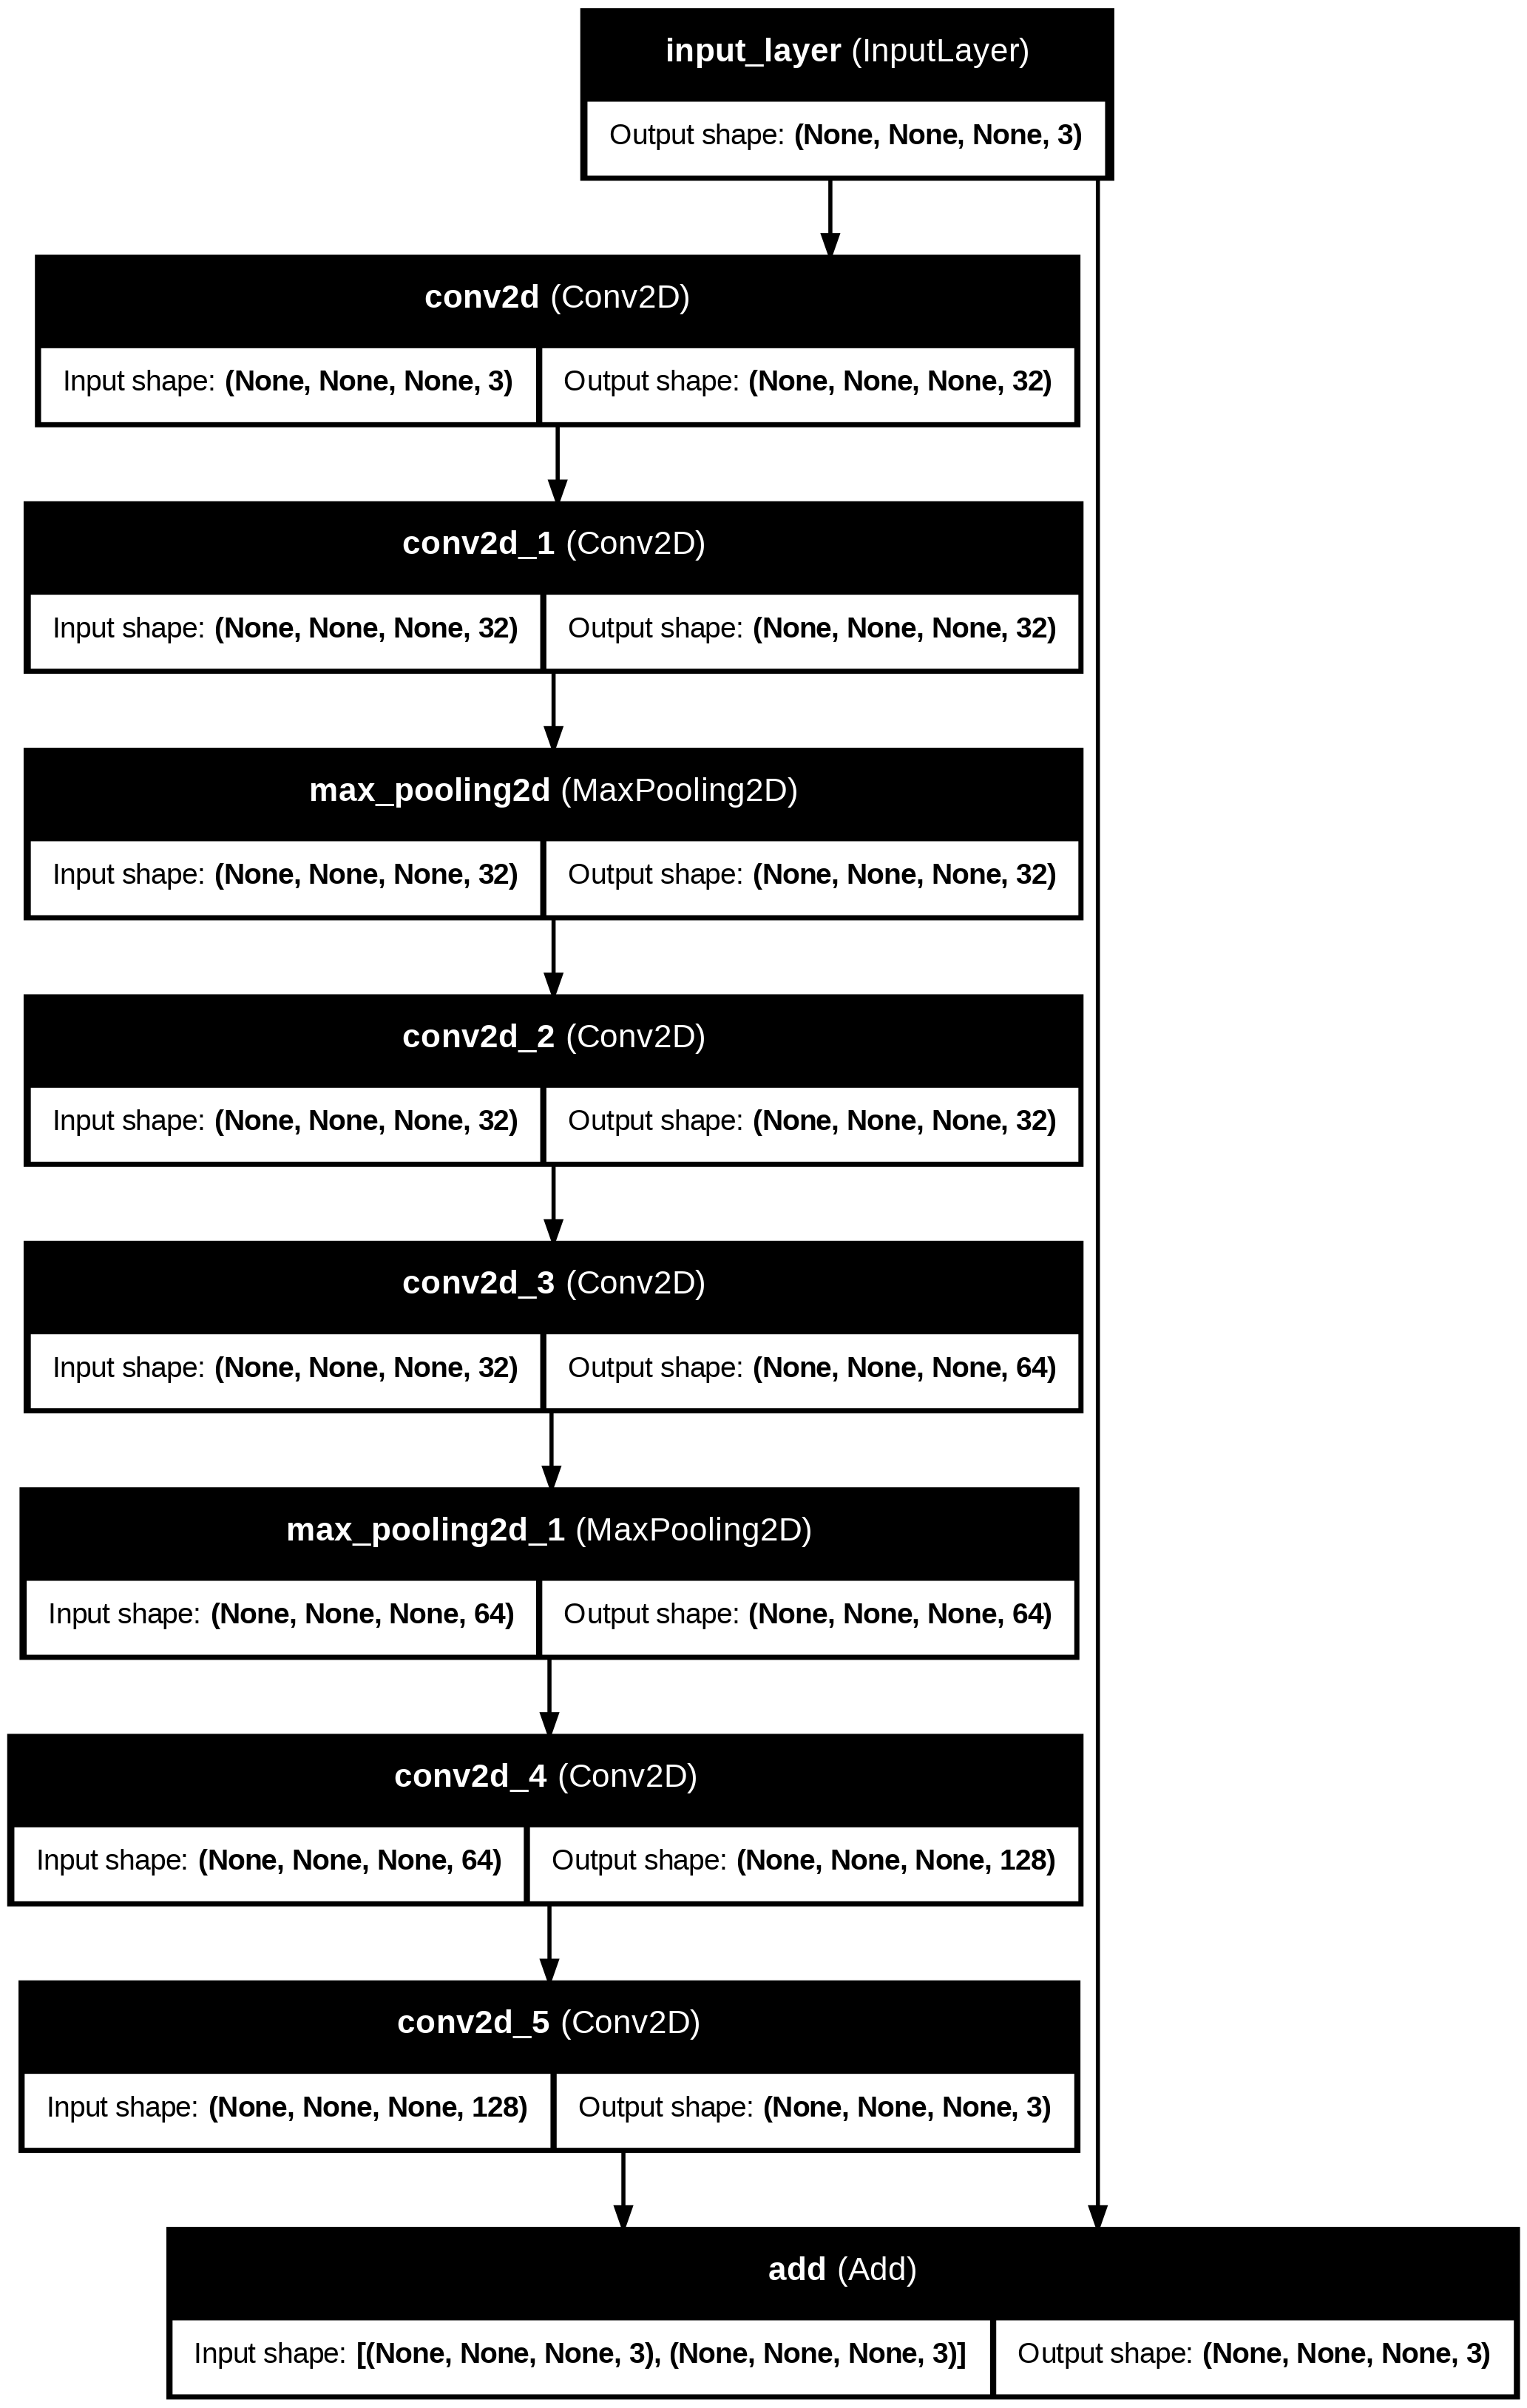

In [ ]:
plot_model(model, to_file= os.path.join(model_info_path, model_name+'.png'), show_shapes=True, show_layer_names=True)

In [ ]:
# history = model.fit(X_train_reshaped, y_train_encoded, epochs=500, batch_size=8, validation_split=0.2, verbose=1, shuffle=False, callbacks=callbacks_list)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks_list, verbose=1)
save_model(model, os.path.join(model_info_path, model_name+".keras"))

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - loss: 0.3054 - peak_signal_noise_ratio: 59.1134 - val_loss: 0.1294 - val_peak_signal_noise_ratio: 65.3675 - learning_rate: 1.0000e-04
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - loss: 0.1810 - peak_signal_noise_ratio: 63.1083 - val_loss: 0.1257 - val_peak_signal_noise_ratio: 65.5314 - learning_rate: 1.0000e-04
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 0.1651 - peak_signal_noise_ratio: 63.5493 - val_loss: 0.1228 - val_peak_signal_noise_ratio: 65.7789 - learning_rate: 1.0000e-04
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.1621 - peak_signal_noise_ratio: 63.7218 - val_loss: 0.1258 - val_peak_signal_noise_ratio: 65.5059 - learning_rate: 1.0000e-04
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - loss: 0.1582 - peak_signal_noise_ratio: 63.9060 - val_loss: 0.1260 - val_peak_signal_noise_ratio: 65.5827 - learning_rate: 1.0000e-04
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - loss: 

In [ ]:
# save_model(model, os.path.join(model_info_path, model_name+".keras"))
# loaded_model = load_model(os.path.join(model_info_path, model_name+".keras"))

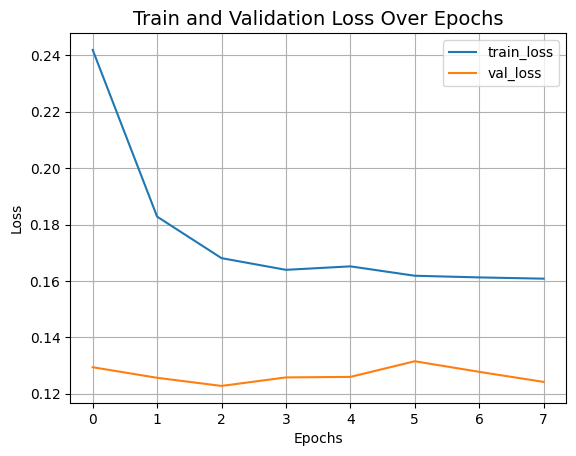

In [ ]:
def plot_history(value, name):
    plt.plot(history.history[value], label=f"train_{name.lower()}")
    plt.plot(history.history[f"val_{value}"], label=f"val_{name.lower()}")
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.title(f"Train and Validation {name} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()
plot_history("loss", "Loss")

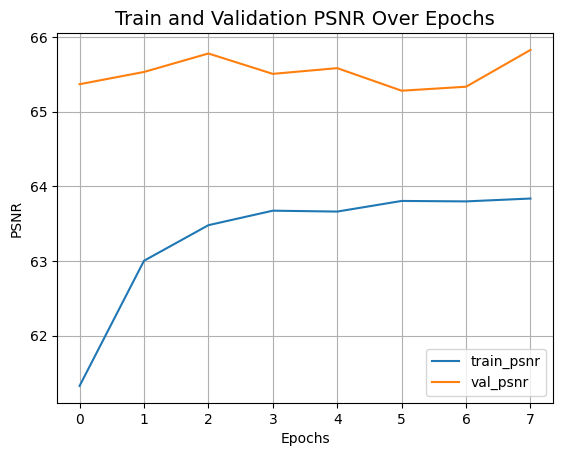

In [ ]:
plot_history("peak_signal_noise_ratio", "PSNR")

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [ ]:
def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    custom_objects = {'peak_signal_noise_ratio': peak_signal_noise_ratio}
    model = load_model(os.path.join(model_info_path, model_name+".keras"), custom_objects=custom_objects)
    output = model.predict(image, verbose=0)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape((np.shape(output_image)[0], np.shape(output_image)[1], 3))
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image

In [ ]:
# for low_light_image in random.sample(test_low_light_images, 6):
for low_light_image in test_low_light_images:
  original_image = Image.open(low_light_image)
  enhanced_image = infer(original_image)
  plot_results([original_image, enhanced_image],["Original", "CNN Model"],(16, 10),)

Output hidden; open in https://colab.research.google.com to view.

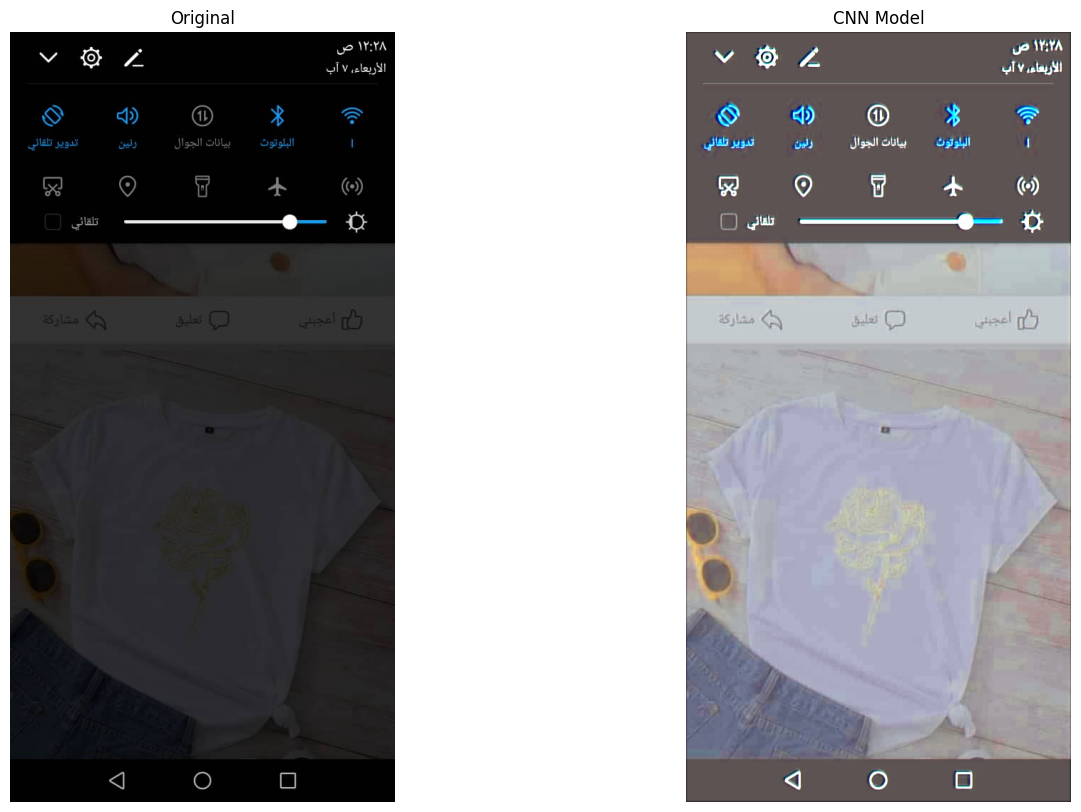

In [ ]:
real_wrold_image_path = os.path.join(data_path, 'test.jpg')
original_image = Image.open(real_wrold_image_path)
enhanced_image = infer(original_image)
plot_results([original_image, enhanced_image],["Original", "CNN Model"],(16, 10),)